In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import os
import re
from sklearn import model_selection, svm
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import classification_report, average_precision_score, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
#from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_curve, roc_auc_score

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import MaxPooling1D
from keras.layers import Activation
from keras import optimizers
from keras.layers import Conv1D
from keras.optimizers import SGD #Stochastic Gradient Descent Optimizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding

from keras.applications import inception_v3

import livelossplot
from livelossplot import PlotLossesKeras
plot_losses = livelossplot.PlotLossesKeras()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

Using TensorFlow backend.


## Data Set Injestion

In [2]:
path_to_dir="E:/HRC Code Base/Desktop Codes/hackerearth/"

In [3]:
train=pd.read_csv(path_to_dir+'train.csv',sep=',',encoding="utf-8",error_bad_lines=False,low_memory = False)
building_ownership=pd.read_csv(path_to_dir+'Building_Ownership_Use.csv',sep=',',encoding="utf-8",error_bad_lines=False,low_memory = False)
building_structure=pd.read_csv(path_to_dir+'Building_Structure.csv',sep=',',encoding="utf-8",error_bad_lines=False,low_memory = False)

In [4]:
#Merging Building Details
building_det=pd.merge(building_ownership,building_structure,on=['building_id','vdcmun_id','district_id','ward_id'],how='inner')

In [5]:
#Merging Building Details With Train Set
mega_data=pd.merge(train,building_det,on=['building_id','vdcmun_id','district_id'],how='inner')

In [6]:
mega_data.head()

,area_assesed,building_id,damage_grade,district_id,has_geotechnical_risk,has_geotechnical_risk_fault_crack,has_geotechnical_risk_flood,has_geotechnical_risk_land_settlement,has_geotechnical_risk_landslide,has_geotechnical_risk_liquefaction,has_geotechnical_risk_other,has_geotechnical_risk_rock_fall,has_repair_started,vdcmun_id,ward_id,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq
0,Both,24385bfd2a2,Grade 4,24,0.0,0,0,0,0,0,0,0,0.0,2489,248903,Private,2.0,0.0,0,0,0,0,0,0,0,0,0,0,3,3,21,385,20,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1,0,0,0,0,0,0,0,0,0,0,Damaged-Not used
1,Both,405d1bbebbf,Grade 2,44,0.0,0,0,0,0,0,0,0,1.0,4423,442304,Private,1.0,1.0,0,1,0,0,0,0,0,0,0,0,3,3,33,602,24,24,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,TImber/Bamboo-Mud,Attached-1 side,Rectangular,0,1,0,0,1,0,0,0,0,0,0,Damaged-Repaired and used
2,Both,351d9bc71f6,Grade 1,36,0.0,0,0,0,0,0,0,0,0.0,3650,365008,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0,3,3,2,700,21,21,Steep slope,RC,RCC/RB/RBC,RC,RCC/RB/RBC,Attached-1 side,Rectangular,0,0,0,0,0,0,0,0,0,1,0,Not damaged
3,Building removed,2be3a971166,Grade 5,30,0.0,0,0,0,0,0,0,0,0.0,3016,301605,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0,3,0,3,315,20,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Timber-Planck,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Rubble clear
4,Both,34c7d073ea6,Grade 3,36,0.0,0,0,0,0,0,0,0,0.0,3627,362705,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0,2,2,22,285,18,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Used in risk


### PreProcessing

In [7]:
#To check the Number of Families Having Null
mega_data.columns[mega_data.isna().any()]

Index(['has_repair_started', 'count_families'], dtype='object')

In [8]:
#Imputation of Columns with Mean and Mode
from sklearn.preprocessing import Imputer
imput = Imputer(strategy='most_frequent')
imput1 = Imputer(strategy='mean')
mega_data['count_families'] = imput1.fit_transform(mega_data[['count_families']]).astype('int')
mega_data['has_repair_started'] = imput.fit_transform(mega_data[['has_repair_started']]).astype('int')

#### From the Features it can be inferred that the Grade of Damage can be predicted only one the basis of the risk factor of a particular building and also based on the specifications of the building.
*Therefore Going With Following Variables*
1. *A Risk Variable for Determining the Summation of Risk Factors*
2. *An Average, Count and Ratio Feature Based on Municipal, District and Ward For Coorelating* [A different Method of String Concatenation Could be used, But Not in the Favour of That]
2. *The Height and And No of Floors of a Building*

In [9]:
mega_data['Risk_Factor']=mega_data['has_geotechnical_risk_other']+mega_data['has_geotechnical_risk_liquefaction']+ mega_data['has_geotechnical_risk_landslide'] + mega_data['has_geotechnical_risk_flood'] + mega_data['has_geotechnical_risk_rock_fall'] + mega_data['has_geotechnical_risk_land_settlement'] + mega_data['has_geotechnical_risk_fault_crack']

In [10]:
mega_data['Risk_Factor'].describe()

count    631761.000000
mean          0.194434
std           0.589000
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: Risk_Factor, dtype: float64

### District Level

In [11]:
# Sum Feature and Average Feature
district_list=mega_data.district_id.unique().tolist()

mega_data['Risk_Factor_District_Sum']=0
mega_data['Risk_Factor_District_Average']=0

for dist in district_list:
    temp_new = pd.DataFrame()
    temp_new = mega_data.loc[mega_data.district_id == dist, :]
    temp_new = temp_new.reset_index()
    temp_new.drop('index', axis=1, inplace=True)
        
    sum_feat=temp_new['Risk_Factor'].sum()
    avg_feat=sum_feat/len(temp_new)
   
    mega_data['Risk_Factor_District_Sum']=np.where(mega_data['district_id']==dist, sum_feat, mega_data['Risk_Factor_District_Sum'])
    mega_data['Risk_Factor_District_Average']=np.where(mega_data['district_id']==dist, avg_feat, mega_data['Risk_Factor_District_Average'])

### Municipal Level

In [12]:
municipal_list=mega_data.vdcmun_id.unique().tolist()

mega_data['Risk_Factor_Municipal_Sum']=0
mega_data['Risk_Factor_Municipal_Average']=0

for mun in municipal_list:
    temp_new = pd.DataFrame()
    temp_new = mega_data.loc[mega_data.vdcmun_id == mun, :]
    temp_new = temp_new.reset_index()
    temp_new.drop('index', axis=1, inplace=True)
        
    sum_feat=temp_new['Risk_Factor'].sum()
    avg_feat=sum_feat/len(temp_new)
   
    mega_data['Risk_Factor_Municipal_Sum']=np.where(mega_data['vdcmun_id']==mun, sum_feat, mega_data['Risk_Factor_Municipal_Sum'])
    mega_data['Risk_Factor_Municipal_Average']=np.where(mega_data['vdcmun_id']==mun, avg_feat, mega_data['Risk_Factor_Municipal_Average'])

### Ward Level

In [13]:
ward_list=mega_data.ward_id.unique().tolist()

mega_data['Risk_Factor_Ward_Sum']=0
mega_data['Risk_Factor_Ward_Average']=0

for ward in ward_list:
    temp_new = pd.DataFrame()
    temp_new = mega_data.loc[mega_data.ward_id == ward, :]
    temp_new = temp_new.reset_index()
    temp_new.drop('index', axis=1, inplace=True)
        
    sum_feat=temp_new['Risk_Factor'].sum()
    avg_feat=sum_feat/len(temp_new)
   
    mega_data['Risk_Factor_Ward_Sum']=np.where(mega_data['ward_id']==mun, sum_feat, mega_data['Risk_Factor_Ward_Sum'])
    mega_data['Risk_Factor_Ward_Average']=np.where(mega_data['ward_id']==mun, avg_feat, mega_data['Risk_Factor_Ward_Average'])

In [14]:
#Floor Difference
mega_data['Difference_In_Floors'] = mega_data['count_floors_pre_eq']-mega_data['count_floors_post_eq']

In [15]:
#Height Difference
mega_data['Difference_In_Height'] =mega_data['height_ft_pre_eq']-mega_data['height_ft_post_eq']

In [16]:
#Normal Label Encoding
grade_enc = {'Grade 1':1,'Grade 2':2,'Grade 3':3,'Grade 4':4,'Grade 5':5}
labels_norm=mega_data['damage_grade'].map(grade_enc)

# On-hot Encoding
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
labels_one_hot= encoder.fit_transform(labels_norm)

In [17]:
### Removing Unwanted Columns
mega_data = mega_data.drop(columns=['building_id','damage_grade'])

In [20]:
## Transforming All the Columns having Object Type to One Hot Encoding
for col in mega_data.columns:
    if mega_data[col].dtype == 'object':
        dummy=pd.get_dummies(mega_data[col],prefix=col)
        mega_data=pd.concat([mega_data, dummy], axis=1)
        mega_data.drop(col, axis=1,inplace=True)

In [21]:
#Removing ID Columns
mega_data.drop(['district_id','vdcmun_id','ward_id'], axis=1, inplace=True)

### Non-Parametric Models

In [22]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(mega_data, labels_norm, test_size = 0.3, random_state =9, stratify=labels_norm)

In [23]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()
scaler.fit(train_features)  
train_features = scaler.transform(train_features)  
test_features = scaler.transform(test_features)

In [24]:
model=RandomForestClassifier(random_state=22, n_estimators=200, max_depth=10)
model.fit(train_features,train_labels)
predictions=model.predict(test_features)
print(accuracy_score(test_labels, predictions))
print(confusion_matrix(test_labels, predictions))
print(classification_report(test_labels, predictions))

0.7150726274079429
[[14960  1692  1659    85     0]
 [  222  8294 12690  4319     0]
 [    4  4403 17719 14560     1]
 [    2  1077 10031 34561     2]
 [    2    45   294  2914 59993]]
             precision    recall  f1-score   support

          1       0.98      0.81      0.89     18396
          2       0.53      0.32      0.40     25525
          3       0.42      0.48      0.45     36687
          4       0.61      0.76      0.68     45673
          5       1.00      0.95      0.97     63248

avg / total       0.73      0.72      0.72    189529



In [25]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly
plotly.tools.set_credentials_file(username='c.sabyasachi99', api_key='y5FSl1jIheriCgKbK3Ff')

In [26]:
features=mega_data.columns
importances = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(train_features.shape[1]):
    print( (features[indices[f]], importances[indices[f]]))

Feature ranking:
('count_floors_post_eq', 0.1753418787110088)
('Difference_In_Height', 0.11526705057195413)
('height_ft_post_eq', 0.11365658356043834)
('Difference_In_Floors', 0.09398132196024837)
('condition_post_eq_Not damaged', 0.08875646632790136)
('area_assesed_Building removed', 0.05829927809006302)
('condition_post_eq_Damaged-Not used', 0.05149426847597316)
('area_assesed_Both', 0.04784745457808769)
('condition_post_eq_Damaged-Rubble unclear', 0.04505994150511929)
('condition_post_eq_Damaged-Used in risk', 0.02801818053275085)
('condition_post_eq_Damaged-Repaired and used', 0.02595659768804017)
('condition_post_eq_Damaged-Rubble clear', 0.021095719602901453)
('has_repair_started', 0.018703807205346076)
('foundation_type_Mud mortar-Stone/Brick', 0.011888155945697605)
('Risk_Factor_District_Sum', 0.010631711968426048)
('Risk_Factor_District_Average', 0.008845944219010143)
('condition_post_eq_Damaged-Rubble Clear-New building built', 0.00863047770048736)
('has_superstructure_mud_mo

In [27]:
trace = go.Bar(x=features, y=importances[indices],
               marker=dict(color='red'),
               error_y=dict(visible=True, arrayminus=std[indices]),
               opacity=0.5)

layout = go.Layout(title="Feature importances")
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Convolutional Neural Network

In [28]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(mega_data, labels_one_hot, test_size = 0.3, random_state =9, stratify=labels_one_hot)

In [29]:
test_labels

array([[0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0]])

In [30]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()
scaler.fit(train_features)  
train_features = scaler.transform(train_features)  
test_features = scaler.transform(test_features)  

In [31]:
train_features=train_features.reshape(train_features.shape[0], train_features.shape[1], 1)
test_features=test_features.reshape(test_features.shape[0], test_features.shape[1], 1)

In [32]:
print(train_features.shape)
print(test_features.shape)

(442232, 98, 1)
(189529, 98, 1)


In [33]:
print(train_labels.shape)
print(test_labels.shape)

(442232, 5)
(189529, 5)


In [34]:
import livelossplot
from livelossplot import PlotLossesKeras
plot_losses = livelossplot.PlotLossesKeras()

In [35]:
def createModel():
    model = Sequential()
    model.add(Conv1D(128, 10, input_shape=(98,1,), activation='relu'))
    model.add(Conv1D(64, 2, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    #stochastic gradient descent
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

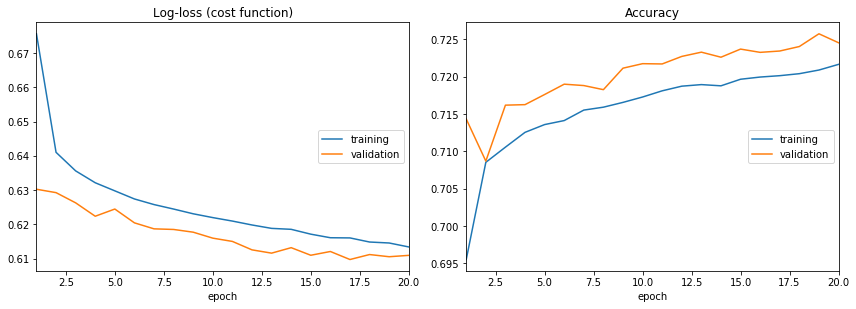

Log-loss (cost function):
training   (min:    0.613, max:    0.676, cur:    0.613)
validation (min:    0.610, max:    0.630, cur:    0.611)

Accuracy:
training   (min:    0.696, max:    0.722, cur:    0.722)
validation (min:    0.709, max:    0.726, cur:    0.725)


In [36]:
model = createModel()
history=model.fit(train_features,train_labels, epochs=20, batch_size=10,validation_data=(test_features,test_labels),callbacks=[plot_losses])

In [37]:
scores = model.evaluate(test_features, test_labels)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

189529/189529 [==============================] - 9s 48us/step

acc: 72.45%


## Artificial Neural Network

In [59]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(mega_data, labels_one_hot, test_size = 0.3, random_state =9, stratify=labels_one_hot)

In [60]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()
scaler.fit(train_features)  
train_features = scaler.transform(train_features)  
test_features = scaler.transform(test_features) 

In [61]:
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)

(442232, 98)
(189529, 98)
(442232, 5)
(189529, 5)


In [62]:
import livelossplot
from livelossplot import PlotLossesKeras
plot_losses = livelossplot.PlotLossesKeras()

In [65]:
def create_network():
    model = Sequential()
    model.add(Dense(60, input_shape=(98,), activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='softmax'))
        
    #stochastic gradient descent
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

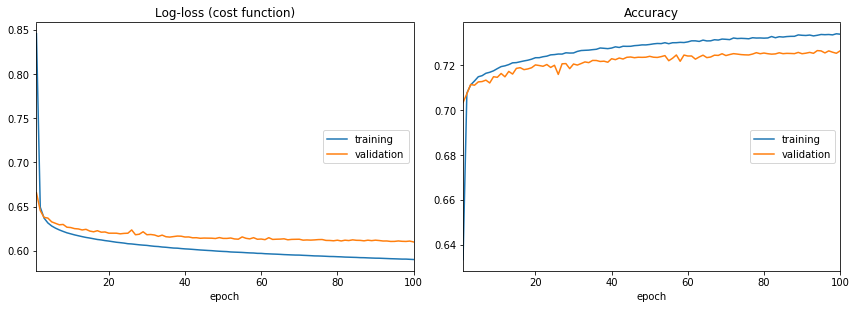

Log-loss (cost function):
training   (min:    0.590, max:    0.845, cur:    0.590)
validation (min:    0.610, max:    0.665, cur:    0.610)

Accuracy:
training   (min:    0.633, max:    0.734, cur:    0.734)
validation (min:    0.703, max:    0.726, cur:    0.726)
189529/189529 [==============================] - 5s 27us/step

acc: 72.62%


In [66]:
model3 = create_network()
model3.fit(train_features,train_labels, epochs=100, batch_size=100,validation_data=(test_features,test_labels), callbacks=[plot_losses])
scores = model3.evaluate(test_features, test_labels)
print("\n%s: %.2f%%" % (model3.metrics_names[1], scores[1]*100))